In [15]:
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv('80QS.csv')

C:\Users\iwell\AppData\Local\Temp\ipykernel_28456\3503526940.py:1: DtypeWarning: Columns (29,30,35,44,45,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('80QS.csv')


In [17]:
cols = [
    'años de graduación',
    'Since graduating from Tecnológico de Monterrey, have you founded a nonprofit organization, as part of the founding group or main founder?',
    'How many organizations have you founded?',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Foundation year  organization 1',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Foundation year  organization 2',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Foundation year  organization 3',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Foundation year  organization 4',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Foundation year  organization 5',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  # of years in operation  organization 1',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  # of years in operation  organization 2',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  # of years in operation  organization 3',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  # of years in operation  organization 4',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  # of years in operation  organization 5',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Number of employees in the last year  organization 1',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Number of employees in the last year  organization 2',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Number of employees in the last year  organization 3',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Number of employees in the last year  organization 4',
    'Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Number of employees in the last year  organization 5',

    'How much money per year do you donate to social organizations? If you donate in another currency, please select an approximate amount in Mexican pesos..',
    'Would you please share an estimate amount of how many hours per MONTH you donate to social organizations?  hours per month',
]

In [ ]:
def add_impact_score(df):
    # Mappings
    years_operation_map = {
        "less than 1": 1,
        "from 2 to 5": 7,
        "from 6 to 10": 16,
        "from 11 to 15": 26,
        "from 16 to 30": 46,
        "More than 30": 70
    }

    employees_map = {
        "self employment": 0.5,
        "From 1 to 10 employees": 5,
        "From 11 to 50 employees": 25,
        "From 51 to 100 employees": 75,
        "More than 100 employees": 250,
        "From 500 to 999 employees": 750,
        "From 1,000 to 2,499 employees": 1500,
        "2,500 or more employees": 3000
    }

    donation_map = {
        "Less than 1,000 Mexican Pesos": 2,
        "From 1,001 to 5,000 Mexican Pesos": 6,
        "From 5,001 to 10,000 Mexican Pesos": 10,
        "More than 10,000 Mexican Pesos": 20,
    }

    # Helper to clean numeric or mapped text
    def map_or_numeric(val, mapping):
        if pd.isna(val):
            return 0
        if isinstance(val, str):
            val = val.strip()
            if val in mapping:
                return mapping[val]
            try:
                return float(val)
            except ValueError:
                return 0
        elif isinstance(val, (int, float)):
            return val
        return 0

    # Number of orgs
    df["num_orgs"] = df["How many organizations have you founded?"].apply(
        lambda x: int(x) if pd.notna(x) and str(x).isdigit() else 0
    )

    # Years of operation
    operation_cols = [
        col for col in df.columns if "Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  # of years in operation  organization " in col]
    df["years_operation"] = df[operation_cols].apply(
        lambda row: sum(map_or_numeric(v, years_operation_map) for v in row), axis=1
    )

    # Number of employees
    employee_cols = [
        col for col in df.columns if "Por favor, nos puede proporcionar la siguiente información de las principales organizaciones soci...  Number of employees in the last year  organization" in col]
    df["total_employees"] = df[employee_cols].apply(
        lambda row: sum(map_or_numeric(v, employees_map) for v in row), axis=1
    )

    # Combined years of operation * employees
    df["combined_operation_employees"] = df["years_operation"] * \
        df["total_employees"]

    # Donation
    df["donation_score"] = df[
        "How much money per year do you donate to social organizations? If you donate in another currency, please select an approximate amount in Mexican pesos.."
    ].apply(lambda x: map_or_numeric(x, donation_map))

    # Volunteer time (monthly → annualized)
    df["volunteer_hours"] = df[
        "Would you please share an estimate amount of how many hours per MONTH you donate to social organizations?  hours per month"
    ].fillna(0).astype(float) * 12

    # Final weighted score using combined metric
    df["impact_score"] = (
        10 * df["num_orgs"] +
        3 * df["combined_operation_employees"] +
        2 * df["volunteer_hours"] +
        1 * df["donation_score"]
    )

    return df

In [33]:
test = add_impact_score(df)

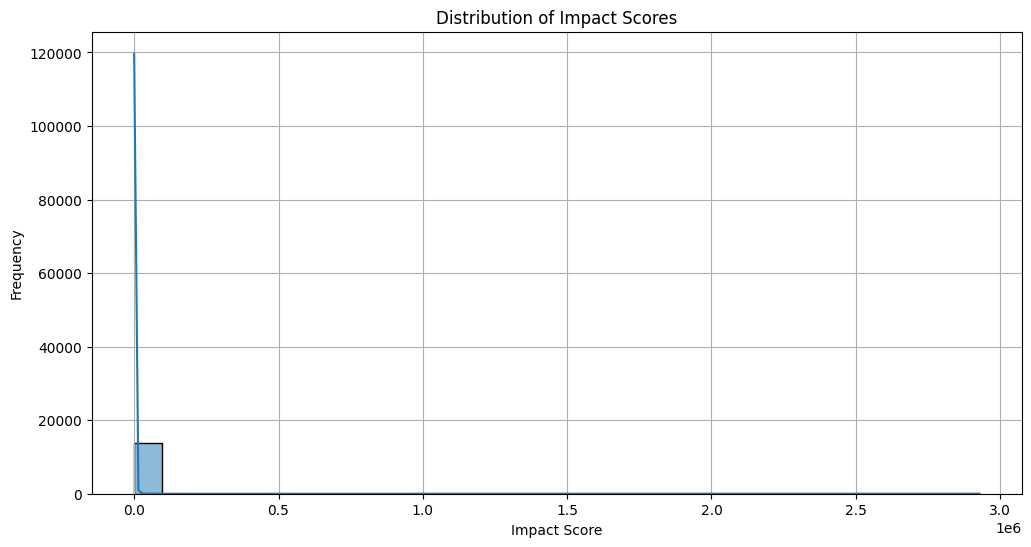

In [53]:
def plot_impact_score(df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 6))
    sns.histplot(df[df['impact_score'] != 0]
                 ['impact_score'], bins=30, kde=True)
    plt.title('Distribution of Impact Scores')
    plt.xlabel('Impact Score')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()


plot_impact_score(test)

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

Filtered max value: 315.0
Upper bound: 315.0
Q3: 126.0
Original max value: 2928900.0


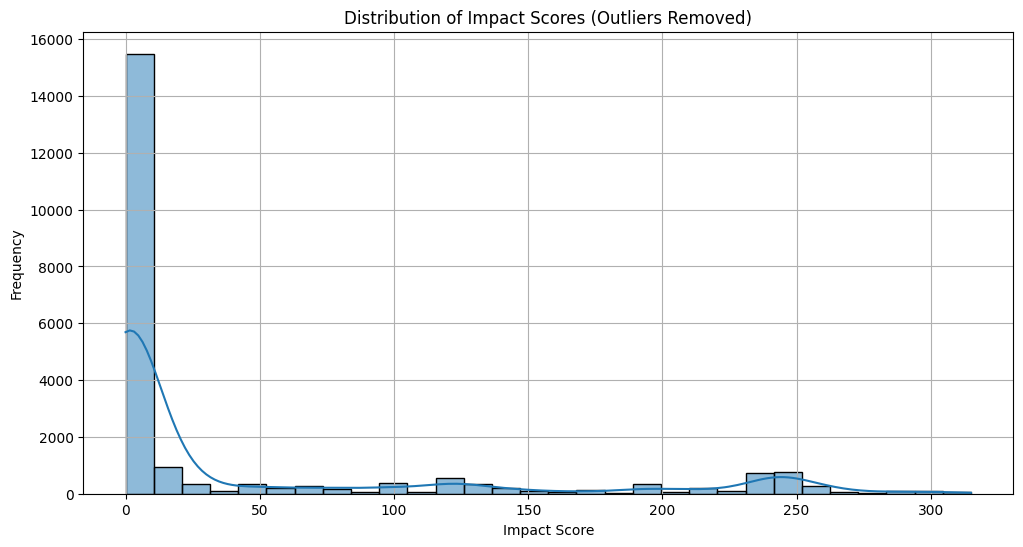

In [ ]:
def plot_impact_score_removing_outliers(df):
    # remove outliers based on the 1.5*IQR rule
    Q1 = df['impact_score'].quantile(0.25)
    Q3 = df['impact_score'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df['impact_score'] >= lower_bound) &
                     (df['impact_score'] <= upper_bound)]

    print(f"Filtered max value: {filtered_df['impact_score'].max()}")
    print(f"Upper bound: {upper_bound}")
    print(f"Q3: {Q3}")
    print(f"Original max value: {df['impact_score'].max()}")

    plt.figure(figsize=(12, 6))
    sns.histplot(filtered_df['impact_score'], bins=30, kde=True)
    plt.title('Distribution of Impact Scores (Outliers Removed)')
    plt.xlabel('Impact Score')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()


plot_impact_score_removing_outliers(test)

In [35]:
print("Avg Impact Score:", test['impact_score'].mean())
print("Max Impact Score:", test['impact_score'].max())
print("Min Impact Score:", test['impact_score'].min())
print("Std Dev Impact Score:", test['impact_score'].std())
print("Total Organizations:", test['num_orgs'].sum())

Avg Impact Score: 545.5255737834214
Max Impact Score: 2928900.0
Min Impact Score: 0.0
Std Dev Impact Score: 21829.244750368747
Total Organizations: 2111


In [36]:
# get the max impact score row
max_impact_row = test.loc[test['impact_score'].idxmax()]
print("Max Impact Score Row:")
# print as a dictionary
print(max_impact_row.to_dict())

Max Impact Score Row:
{'External Data Reference': 'IQA05MTY168848', 'Gender': 'M', 'Campus': 'Monterrey', 'programa nombre': 'Ingeniero Químico Administrador', 'nivel_descripción': 'Profesional', 'escuela': 'Ingeniería y Ciencias', 'años de graduación': '1978', 'Decada': '70´s', 'lustro': '70´s  2', 'AGE': 64, 'nationality': 'Mexican', 'living country': 'México', 'In which state do you live?': 'Nuevo León', 'living country  before studies': 'México', 'living state  before studies': 'Nuevo León', 'Which is the education level of your parents?  Father': 'Technical Career', 'Which is the education level of your parents?  Mother': 'Primary level', 'Which of the following best describes the occupation of your father and mother when you began your studies at Tecnologico de Monterrey?  Father': 'Employee of a company', 'Which of the following best describes the occupation of your father and mother when you began your studies at Tecnologico de Monterrey?  Mother': 'Housework', 'During your stu

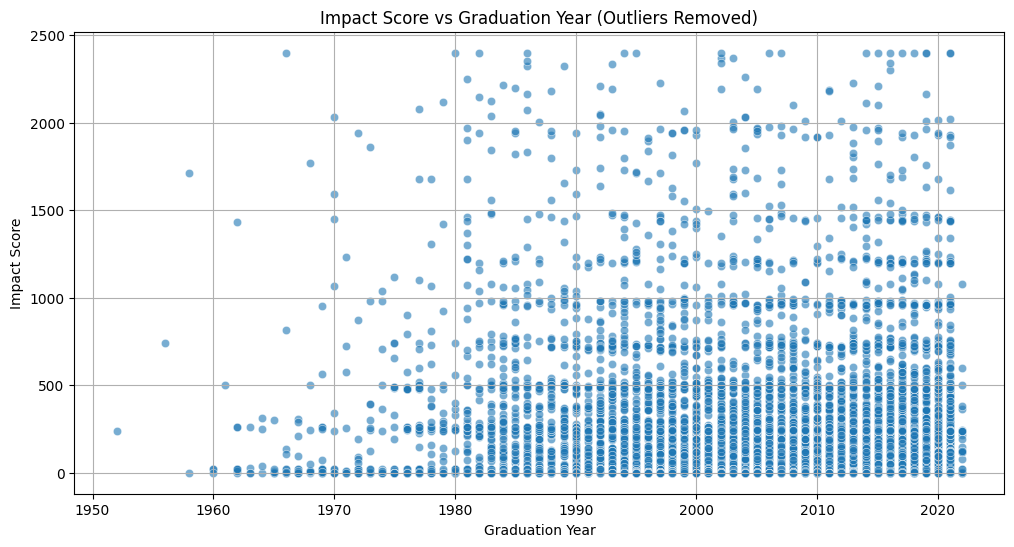

Original data points: 25358
Filtered data points: 25118
Outliers removed: 240


In [ ]:
# plot the impact score vs years of graduation (removing outliers)
def plot_impact_score_vs_graduation_year(df):
    # Remove top 10% highest impact scores as outliers
    threshold = df['impact_score'].quantile(0.99)
    lower_bound = df['impact_score'].min()
    upper_bound = threshold

    # Filter out outliers
    filtered_df = df[(df['impact_score'] >= lower_bound) &
                     (df['impact_score'] <= upper_bound)]

    # Convert graduation years to numeric
    graduation_years = pd.to_numeric(
        filtered_df['años de graduación'], errors='coerce')
    impact_scores = filtered_df['impact_score']

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=graduation_years, y=impact_scores, alpha=0.6)
    plt.title('Impact Score vs Graduation Year (Outliers Removed)')
    plt.xlabel('Graduation Year')
    plt.ylabel('Impact Score')
    plt.grid()
    plt.show()

    print(f"Original data points: {len(df)}")
    print(f"Filtered data points: {len(filtered_df)}")
    print(f"Outliers removed: {len(df) - len(filtered_df)}")


plot_impact_score_vs_graduation_year(test)

In [70]:
def remove_outliers(df):
    # Remove outliers for 0.99 quantile
    threshold = df['impact_score'].quantile(0.99)
    lower_bound = df['impact_score'].min()
    upper_bound = threshold
    return df[(df['impact_score'] >= lower_bound) & (df['impact_score'] <= upper_bound)]

C:\Users\iwell\AppData\Local\Temp\ipykernel_28456\2146853091.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='años de graduación', y='impact_score',


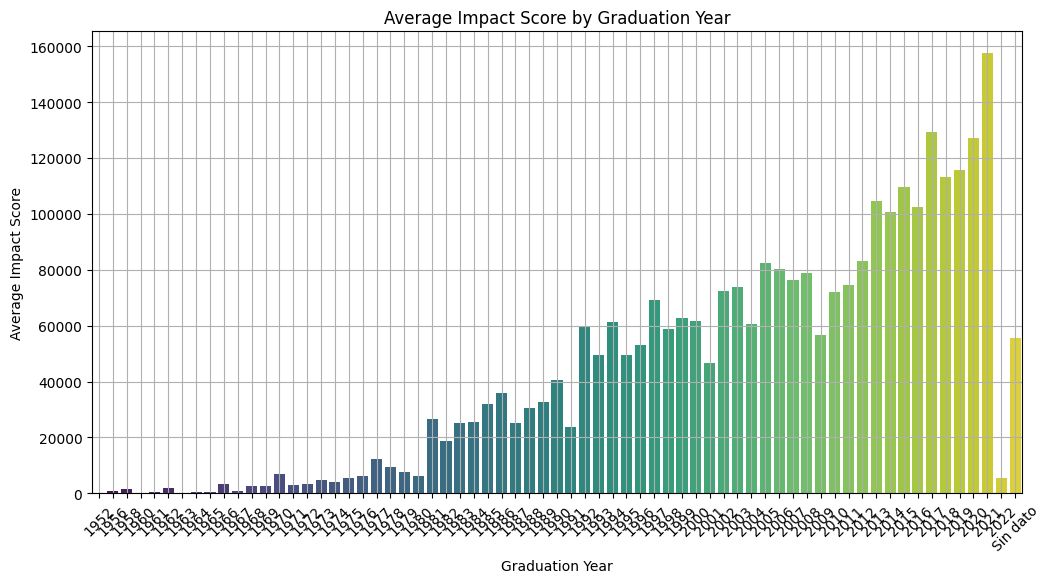

In [71]:
def plot_grouped_impact_scores(df):
    # Group by graduation year and calculate mean impact score
    df = remove_outliers(df)
    grouped = df.groupby('años de graduación')[
        'impact_score'].sum().reset_index()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='años de graduación', y='impact_score',
                data=grouped, palette='viridis')
    plt.title('Average Impact Score by Graduation Year')
    plt.xlabel('Graduation Year')
    plt.ylabel('Average Impact Score')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


plot_grouped_impact_scores(test)